# Example usage of raytracing module

In [1]:
from pythonradex import molecule
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
#add the raytracing module:
import sys
#path to the folder that contains the raytracing.py file:
sys.path.append('/home/gianni/science/projects/code/raytracing')
import raytracing

**NOTE: all input needs to be in SI units**

## Example 1: CO emission from Keplerian disk

In this example, we consider a Keplerian disk. We want to raytrace the CO 3-2 emission from the disk.

First, we define the sky grid over which the model is calculated. By the way, it is a good idea to always check that the grid is fine enough, i.e. make an additional calculation with a finer grid and check that the results do not change.

In [2]:
#x_sky is in the horizontal direction, y_sky along the line of sight away
#from the observer, and z_sky in the vertical direction
x_sky = np.linspace(-100,100,50)*constants.au
y_sky = x_sky.copy()
# since we consider an inclined disk, it's ok if z_sky covers a smaller range:
z_sky = np.linspace(-50,50,60)*constants.au
#velocity grid:
v = np.linspace(-10,10,60)*constants.kilo
grid = {'x_sky':x_sky,'y_sky':y_sky,'z_sky':z_sky,'v':v}

Next, we define the Keplerian velocity field. We consider the coordinates x,y,z and that the disk is placed in the x-y plane. The function needs to return the velocity in the y and z direction.

In [3]:
Mstar = 2e30 #stellar mass in kg
def velocity_yz(x,y,z):
    r = np.sqrt(x**2+y**2)
    v0 = np.sqrt(constants.G*Mstar/r)
    phi = np.arctan2(y,x)
    return [v0*np.cos(phi),np.zeros_like(r)]

Next, we define the temperature that is used to calculate the level populations by assuming a Boltzmann distribution. For example, in LTE, the temperature we define here would be equal to the kinetic temperature of the gas.

In [4]:
T0 = 50
r0 = 50*constants.au
#assume the temperature scales as 1/sqrt(r)
def T_Boltzmann(x,y,z):
    r = np.sqrt(x**2+y**2)
    return T0*(r/r0)**-0.5

Next, we need to define the spatial distribution of the gas. We assume a Gaussian ring centered at r0. The vertical profile is also assumed to be Gaussian

In [5]:
def number_density(x,y,z):
    r = np.sqrt(x**2+y**2)
    H = 10*constants.au
    n0 = 500/constants.centi**3
    sigma = 10*constants.au
    n = n0*np.exp(-(r-r0)**2/(2*sigma**2))*np.exp(-z**2/(2*H**2))
    return n

We also have to set up the pythonradex object that contains all the information about the CO molecule.

In [6]:
#We assume that the intrinsic emission profile is Gaussian
line_profile_type = 'Gaussian' #'rectangular' is also available, see pythonradex documentation
#FWHM of the intrinsic Gaussian emission profile:
width_v = 1.5*constants.kilo
#filepath to the LAMDA file that describes the atomic properties of the species
#here we consider CO
data_filepath = 'co.dat'
atom = molecule.EmittingMolecule(
                 datafilepath=data_filepath,line_profile_type=line_profile_type,
                 width_v=width_v)
#define which transition we want to consider. Here we want the third transition
#listed in the LAMDA file (i.e. CO 3-2), so the index is 2
transition_index = 2

Next, we need to define how the coordinate system x,y,z is inclined with respect to the sky coordinate system. The inclination is achieved by a rotation around the x_sky axis. For a zero inclination, x=x_sky, y=y_sky, z=z_sky. For an inclination of pi/2 (i.e. 90 degrees), x=x_sky, y=z_sky, z=-y_sky. If we put a zero inclination, the disk will be edge-on because we defined our disk to be placed in the x-y plane. Here we set an inclination of 30 degrees, which means that for our particular setup, the disk inclination will be 60 degrees.

In [7]:
inclination_xyz = np.radians(30)

A few extra parameters:

In [8]:
#do not print extra information
verbose = False
#allow large optical depth increase when raytracing along the line of sight:
check_max_optical_depth_increase = False 
# do not allow negative optical depth:
allow_negative_tau = False

Finally, we can define our model and execute the raytracing

In [9]:
model = raytracing.Raytracing(
            grid=grid,T_Boltzmann=T_Boltzmann,number_density=number_density,
            velocity_yz=velocity_yz,atom=atom,transition_index=transition_index,
            inclination_xyz=inclination_xyz,verbose=verbose)
model.raytrace()

Now three additional attributes have been created that contain the results of the calculation:
- `model.cube`: the emission cube (3D numpy array) in units of W/m2/(m/s)/sr. The axes correspond to x_sky, z_sky and v.
- `model.tau_nu`: the optical depth cube (3D numpy array). Again the axes correspond to x_sky, z_sky and v.
- `model.spectrum`: the total spectrum (i.e. the emission cube integrated over x_sky and y_sky)

Check the peak emission of the cube, and plot the spectrum from a single pixel

peak emission: 2.05e-12 W/m2/(m/s)/sr


Text(0, 0.5, 'intensity [W/m2/(m/s)/Hz]')

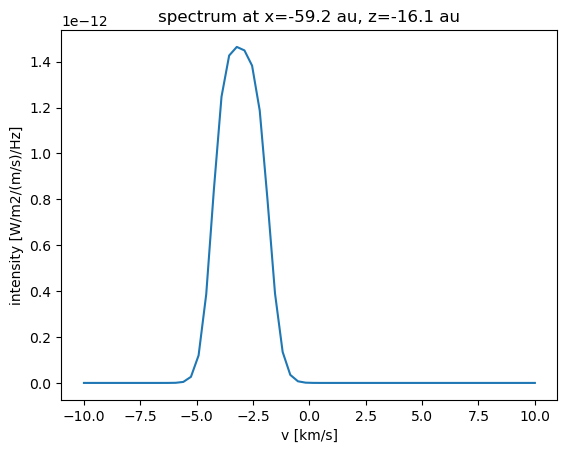

In [10]:
print(f'peak emission: {np.max(model.cube):.3g} W/m2/(m/s)/sr')

ix,iz = 10,20
spec = model.cube[ix,iz,:]
fig,ax = plt.subplots()
ax.set_title(f'spectrum at x={x_sky[ix]/constants.au:.3g}'
             +f' au, z={z_sky[iz]/constants.au:.3g} au')
ax.plot(v/constants.kilo,spec)
ax.set_xlabel('v [km/s]')
ax.set_ylabel('intensity [W/m2/(m/s)/Hz]')

let's look at the optical depth at the same pixel:

Text(0, 0.5, 'optical depth')

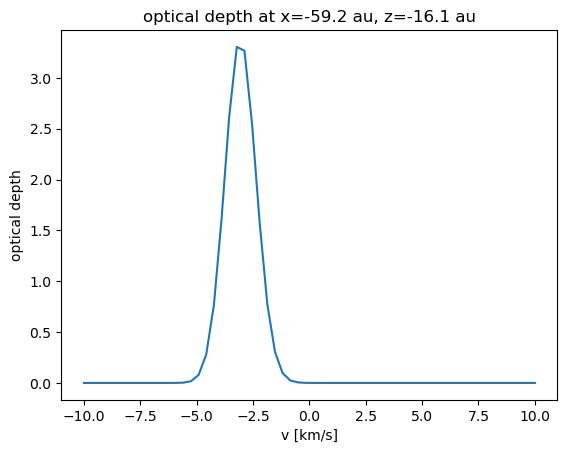

In [11]:
tau = model.tau_nu[ix,iz,:]
fig,ax = plt.subplots()
ax.set_title(f'optical depth at x={x_sky[ix]/constants.au:.3g}'
             +f' au, z={z_sky[iz]/constants.au:.3g} au')
ax.plot(v/constants.kilo,tau)
ax.set_xlabel('v [km/s]')
ax.set_ylabel('optical depth')

plot the total spectrum

Text(0, 0.5, 'flux [W/(m/s)/sr]')

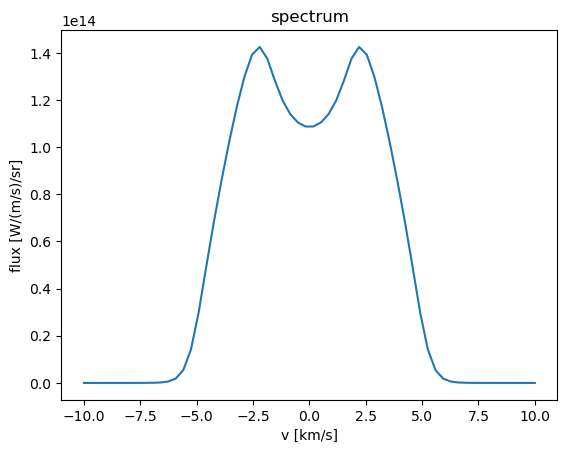

In [12]:
fig,ax = plt.subplots()
ax.set_title('spectrum')
ax.plot(v/constants.kilo,model.spectrum)
ax.set_xlabel('v [km/s]')
ax.set_ylabel('flux [W/(m/s)/sr]')

There are a few convenience functions that give us access to certain plots:

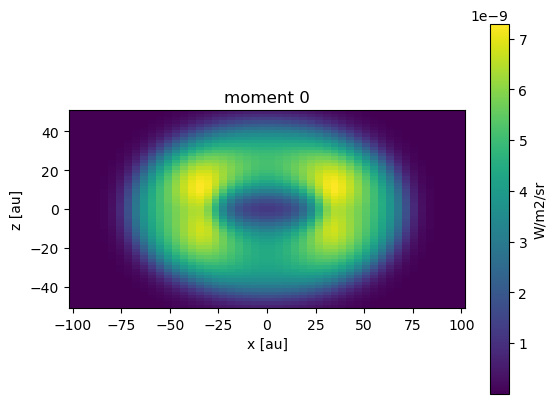

In [13]:
#plot the moment 0 (i.e. the emission cube integrated over v)
model.plot_mom0(title='moment 0')

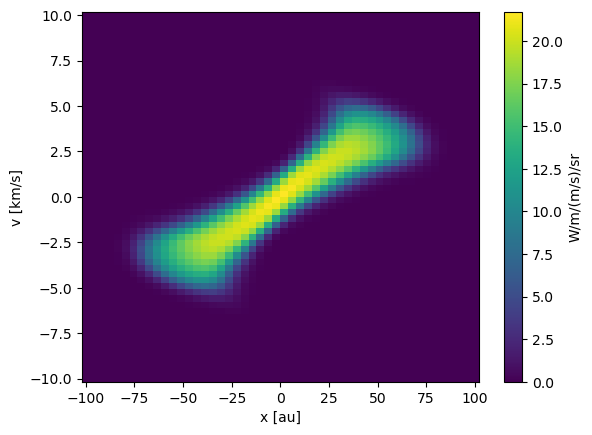

In [14]:
#plot the integration of the emission cube along the z_sky axis
model.plot_pv()

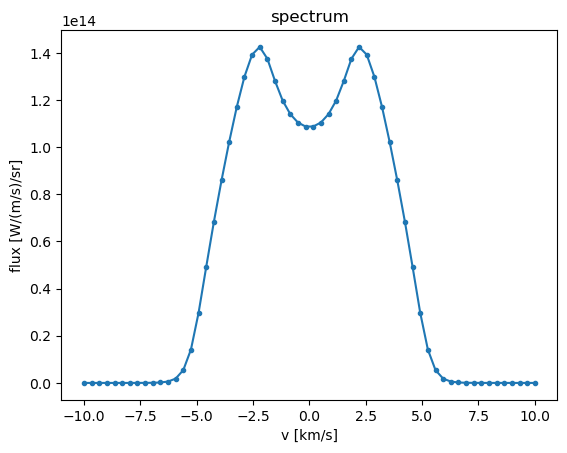

In [15]:
#plot the disk-integrated spectrum (this is the same as we already plotted
#above using model.spectrum)
model.plot_spectrum(title='spectrum')

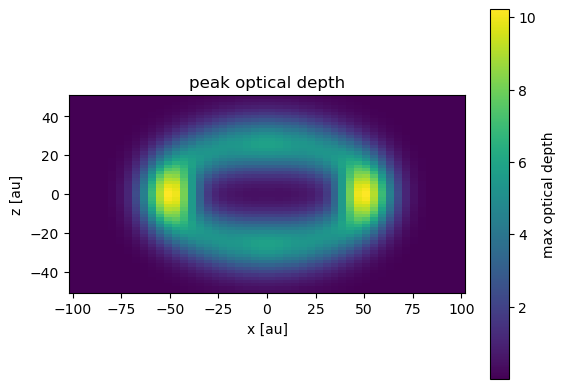

In [16]:
#plot a map of the peak optical depth
model.plot_max_tau_nu(title='peak optical depth')

We can also calculate the total flux (i.e. the emission cube integrated over all axes)

In [17]:
total_flux = model.total_flux(distance=10*constants.parsec)
print('total flux: {:g} W/m2'.format(total_flux))

total flux: 1.14303e-17 W/m2


Finally, let's save the result in .npz format

In [18]:
model.save(filepath='my_model.npz')

## Example 2: supplying level populations directly

In the previous example, the level populations were assumed to follow a Boltzmann distribution and we defined the corresponding temperature. In this example, we will instead input the level populations directly using two functions x1 (the fractional population of the lower level) and x2 (the fractional population of the upper level).

In [19]:
#very simple case: constant x1 and x2
def x1(x,y,z):
    shape = np.broadcast(x,y,z).shape
    return np.ones(shape) * 0.15
def x2(x,y,z):
    shape = np.broadcast(x,y,z).shape
    return np.ones(shape) * 0.1

Define a new model where T_Boltzmann is `None`, and x1 and x2 are added.

In [20]:
model = raytracing.Raytracing(
            grid=grid,T_Boltzmann=None,number_density=number_density,x1=x1,x2=x2,
            velocity_yz=velocity_yz,atom=atom,transition_index=transition_index,
            inclination_xyz=inclination_xyz,verbose=verbose)
model.raytrace()

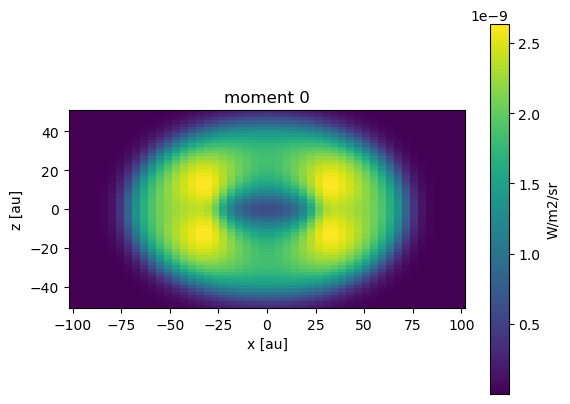

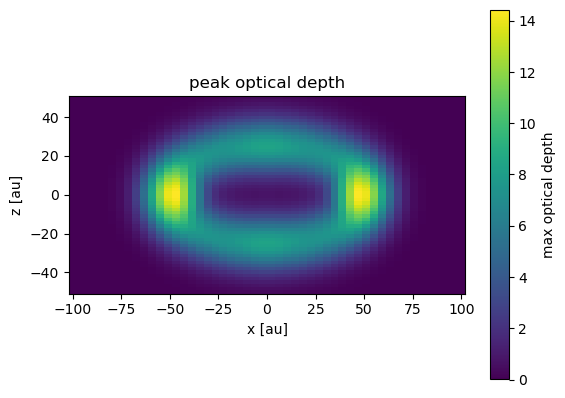

In [21]:
model.plot_mom0(title='moment 0')
model.plot_max_tau_nu(title='peak optical depth')